<a href="https://colab.research.google.com/github/shcho11/00.ML_Practices_2022_School/blob/main/Modeling_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modeling Practices @ '기계학습' 수업
<ul>
  <li> Diabetes Dataset 사용 </li>
  <li> 코드작성 : 조송현 </li>
</ul>

* [Memo] when it comes to this Assignment : 
  - additional task :  "improving score(R2)" and "overcoming Overfitting problem" at the same time
  - To_do : alter ways of Preprocessing, Trying Cross-validation, Grid Search instead of Random search, Setting hyperparameters  

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0


# Prepare the Dataset

We will be using a publicly open diabetes dataset.

We thank BRFSS 2015 organizers for preparing the dataset and Alex Teboul for cleaning it.

Please refer to this [link](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset) for more information on the dataset (e.g., descriptions of each column).

In [ ]:
import numpy as np
import pandas as pd
import os
import hashlib
import urllib.request

#### Include any librarys you need to import here ###

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# To plot pretty figures directly within Jupyter
%matplotlib inline
import matplotlib as mpl
np.random.seed(20220324)

#### Include any librarys you need to import here ###

In [ ]:
DATA_URL = 'https://raw.githubusercontent.com/wltjr1007/wltjr1007.github.io/master/class_datasets/diabetes.csv'
DATA_MD5 = '0c84b09d240b72e8180bceff3965d1bd'
DATA_PATH = '/content/diabetes.csv'
def fetch_diabetes_data():
    def download_data_from_url():
        urllib.request.urlretrieve(DATA_URL, DATA_PATH) # download dataset
    
    def check_data_consistency():
        with open("diabetes.csv", "rb") as f: # open csv file
            data = f.read()
        assert hashlib.md5(data).hexdigest()==DATA_MD5, "Data is not correct. Reset Colab using Ctrl+F12 and rerun this code."

    if not os.path.exists(DATA_PATH):
        download_data_from_url()
    check_data_consistency()
    print("Data is fetched!")

fetch_diabetes_data()

all_data = pd.read_csv(DATA_PATH) # read csv
all_data_size = len(all_data) # len of data

missing_data = all_data.to_numpy().copy() # all_data를 numpy배열로 바꾼 다음 사본으로 생성

for i in np.random.choice(all_data_size, 1000): #모집단 all_data_size에서 1000개 임의표본추출
    j = np.random.randint(0,22) # 정수 난수생성
    missing_data[i,j] = np.nan 

Data is fetched!


<h3>Task 1) Density Histogram of BMI</h3>
<ul>
  <li>BMI 수준별 % 비중을 히스토그램으로 나타내었음. </li>
</ul>

In [ ]:
all_data = pd.DataFrame(all_data)
all_data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


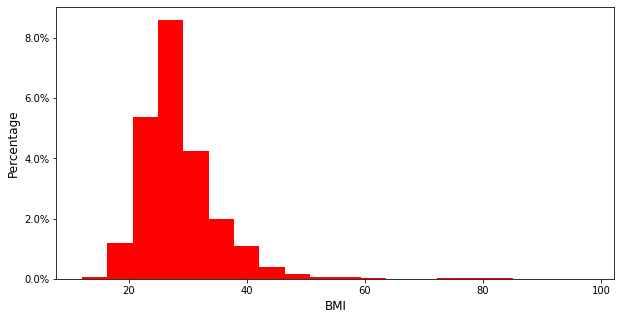

In [ ]:
#matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.rc('axes', unicode_minus = False)
plt.rc('font',family='NanumGothic')

plt.figure(figsize=(10,5))
plt.hist(all_data['BMI'], bins=20, density=True, facecolor='red')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('BMI', fontsize = 12)
plt.ylabel('Percentage', fontsize = 12)
plt.show()

<h3>Task 2) Missing Data Imputation</h3>
<ul>
  <li>missing data의 NaN values를 0으로 치환 처리하였음..  </li>
  <li>missing data의 NaN values를 mean으로 치환 처리하였음.  </li>
</ul>

In [ ]:
missing_data

array([[0., 1., 1., ..., 9., 4., 3.],
       [0., 0., 0., ..., 7., 6., 1.],
       [0., 1., 1., ..., 9., 4., 8.],
       ...,
       [0., 0., 0., ..., 2., 5., 2.],
       [0., 1., 0., ..., 7., 5., 1.],
       [2., 1., 1., ..., 9., 6., 2.]])

In [ ]:
#missing data의 NaN을 전처리 하기 이전 NaN 갯수
np.count_nonzero(np.isnan(missing_data))

1000

In [ ]:
impute_data_zero = np.where(np.isnan(missing_data), 0, missing_data) #0으로 치환
impute_data_mean = np.nanmean(missing_data) #mean으로 치환

print("impute_data_zero nan values?:", np.any(np.isnan(impute_data_zero)))
print("impute_data_mean nan values?:", np.any(np.isnan(impute_data_mean)))

impute_data_zero nan values?: False
impute_data_mean nan values?: False


In [ ]:
#정답 확인
print("전처리 이전 NaN 갯수 : ", np.count_nonzero(np.isnan(missing_data)))
print("0으로 치환 후 NaN 갯수 : ", np.count_nonzero(np.isnan(impute_data_zero)))
print("mean으로 치환 후 NaN 갯수 : ", np.count_nonzero(np.isnan(impute_data_mean)))

전처리 이전 NaN 갯수 :  1000
0으로 치환 후 NaN 갯수 :  0
mean으로 치환 후 NaN 갯수 :  0


<h3>Task 3) Split Dataset(X and Y values) into train/valid/test data</h3>
<ul>
  <li>test data size를 전체 data의 20%으로, valid를 2944개 고정, 나머지를 test data로  </li>
  <li>Diabetes_012 컬럼값이 타겟변수(Y values)이므로 label로 정의하고 dataset에서는 drop시킴  </li>
</ul>

In [ ]:
##데이터셋 Split 하기 

#Split 정의하기 
def split_train_test(data, test_ratio) : 
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  valid_set_size = test_set_size + 2944
  test_indices = shuffled_indices[:test_set_size]
  valid_indices = shuffled_indices[test_set_size:valid_set_size]
  train_indices = shuffled_indices[valid_set_size:]
  return data.iloc[train_indices], data.iloc[valid_indices], data.iloc[test_indices]
train_data, valid_data, test_data = split_train_test(all_data, 0.2)

#레이블은 Diabetes_012 컬럼값
train_label = train_data["Diabetes_012"]
valid_label = valid_data["Diabetes_012"]
test_label = test_data["Diabetes_012"]

#데이터셋을 레이블(y값)컬럼은 Drop하여 재정의
train_data = train_data.drop("Diabetes_012", axis=1)
valid_data = valid_data.drop("Diabetes_012", axis=1)
test_data = test_data.drop("Diabetes_012", axis=1)


print("Test data size correct:", test_data.shape==(all_data_size*.2, 21))
print("Valid data size correct:", valid_data.shape==(2944,21))
print("Train data size correct:", train_data.shape==(all_data_size-len(test_data)-len(valid_data),21))

print("Test label size correct:", test_label.shape==(all_data_size*.2,))
print("Valid label size correct:", valid_label.shape==(2944,))
print("Train label size correct:", train_label.shape==(all_data_size-len(test_data)-len(valid_data),))

Test data size correct: True
Valid data size correct: True
Train data size correct: True
Test label size correct: True
Valid label size correct: True
Train label size correct: True


In [ ]:
#정답 확인
print("Drop 이전 원본데이터의 컬럼 수 : ", len(all_data.columns))
print("Drop 이후 데이터셋의 컬럼 수 : ", len(train_data.columns))
print('\n')
print("원본데이터 number of rows : ", len(all_data))
print("train데이터 number of rows : ", len(train_data))
print("valid데이터 number of rows : ", len(valid_data))
print("test데이터 number of rows : ", len(test_data))
print('\n')
print("train label 갯수 : ", train_label.shape)
print("valid label 갯수 : ", valid_label.shape)
print("test label 갯수 : ", test_label.shape)

Drop 이전 원본데이터의 컬럼 수 :  22
Drop 이후 데이터셋의 컬럼 수 :  21


원본데이터 number of rows :  253680
train데이터 number of rows :  200000
valid데이터 number of rows :  2944
test데이터 number of rows :  50736


train label 갯수 :  (200000,)
valid label 갯수 :  (2944,)
test label 갯수 :  (50736,)


In [ ]:
pd.set_option('display.max_columns', None)
train_data.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
161020,1.0,1.0,1.0,33.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,5.0,0.0,0.0,0.0,8.0,6.0,8.0
26330,0.0,0.0,1.0,20.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,10.0,0.0,0.0,0.0,7.0,6.0,8.0
139720,0.0,0.0,1.0,32.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,2.0,5.0,5.0
124697,1.0,1.0,1.0,32.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,11.0,6.0,5.0
89434,0.0,0.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,4.0,6.0


<h3>Task 4) Preprocessing</h3>
<ul>
  <li>Ordinal Encoder와 MinMax Scaler를 사용함  </li>
  <li>Label value를 0과 1 binary 형태로 치환하기 위해 np.clip을 사용하였음 </li>
  <li>MinMax Scaler를 활용하여 데이터셋 values를 전처리하였음  </li>

</ul>

In [ ]:
#데이터셋 전처리(Preprocessing) 하기 

from sklearn.preprocessing import OrdinalEncoder #문자형을 숫자형으로 변환시켜주는 인코더
from sklearn.preprocessing import MinMaxScaler 
#from sklearn.preprocessing import OneHotEncoder

#Label에서 0과 1로만 바꾸기
train_label = np.clip(train_label, 0, 1).copy()
valid_label = np.clip(valid_label, 0, 1).copy()
test_label = np.clip(test_label, 0, 1).copy()

ordinal_encoder = OrdinalEncoder() 
train_data_encoded = ordinal_encoder.fit_transform(train_data)
valid_data_encoded = ordinal_encoder.fit_transform(valid_data)
test_data_encoded = ordinal_encoder.fit_transform(test_data)
#train_data_encoded[:10]
#ordinal_encoder.categories_

#MinMaxScaler를 이용하여 데이터셋 0~1 범위로 전처리하기
minmax_scaler = MinMaxScaler(feature_range=(0,1.))
train_data = minmax_scaler.fit_transform(train_data_encoded).copy()
valid_data = minmax_scaler.fit_transform(valid_data_encoded).copy()
test_data = minmax_scaler.fit_transform(test_data_encoded).copy()

#OneHotEncoder = OneHotEncoder()
#train_data_1hot = OneHotEncoder.fit_transform(train_data)
#valid_data_1hot = OneHotEncoder.fit_transform(valid_data)
#test_data_1hot = OneHotEncoder.fit_transform(test_data)
#print(train_data_1hot.toarray())
#print(valid_data_1hot.toarray())
#rint(test_data_1hot.toarray())


print("Train data range correct:", np.max(train_data) == 1. and np.min(train_data)==0.)
print("Valid data range correct:", np.max(valid_data) == 1. and np.min(valid_data)==0.)
print("Test data range correct:", np.max(test_data) == 1. and np.min(test_data)==0.)

print("Train label correct:", np.unique(train_label)==(0,1))
print("Valid label correct:", np.unique(valid_label)==(0,1))
print("Test label correct:", np.unique(test_label)==(0,1))

Train data range correct: True
Valid data range correct: True
Test data range correct: True
Train label correct: [ True  True]
Valid label correct: [ True  True]
Test label correct: [ True  True]


In [ ]:
dftrain_data = pd.DataFrame(train_data)
dftrain_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.0,1.0,1.0,0.256098,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.25,0.166667,0.000000,0.0,0.0,0.583333,1.0,1.000000
1,0.0,0.0,1.0,0.097561,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.75,0.333333,0.000000,0.0,0.0,0.500000,1.0,1.000000
2,0.0,0.0,1.0,0.243902,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.50,0.166667,0.033333,0.0,0.0,0.083333,0.8,0.571429
3,1.0,1.0,1.0,0.243902,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.50,0.000000,0.000000,0.0,0.0,0.833333,1.0,0.571429
4,0.0,0.0,1.0,0.170732,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.750000,0.6,0.714286


<h3>Task 5) Modeling</h3>
<ul>
  <li>Random Forest모델을 채택하여 학습 진행  </li>
  <li>Validation 진행 </li>
  <li>sklearn의 Randomized Search를 활용하여 hyperparameter optimization 진행  </li>
  <li>pkl확장자로 모델 저장  </li>
</ul>

In [ ]:
#랜덤포레스트 모델 생성
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=200, random_state=42)

#모델 학습
forest_reg.fit(train_data, train_label)

#n_estimator  : the number of trees in the forest
#max_depth : depth of trees in the forest
#max_features : maximum number of features

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
#초기모델 검증 (모델의 결정계수 출력)
print(forest_reg.score(train_data, train_label))

0.8582483051832234


In [ ]:
#모델의 RMSE를 출력 
#RMSE : root mean squared error. MSE(실제값과 예측값의 차를 제곱하여 평균)의 제곱근

from sklearn.metrics import mean_squared_error

diabetes_predictions = forest_reg.predict(train_data)
forest_mse = mean_squared_error(train_label, diabetes_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.13716212204442205

In [ ]:
#하이퍼파라미터 튜닝
#search space가 크기 때문에 grid search가 아닌 random search로 진행

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': [200, 300, 400, 500, 600],
        'max_features': randint(low=1, high=5),
        'max_depth': randint(low=1, high=5),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
#rnd_search = RandomizedSearchCV(forest_reg(모델명), param_distributions=param_distribs(하이퍼파라미터 조정범위),
#                                n_iter=10(탐색횟수), cv=5(fold 수), scoring='neg_mean_squared_error'(평가방법), random_state=42)
rnd_search.fit(train_data, train_label)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa537a4ed90>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa537a4e210>,
                                        'n_estimators': [200, 300, 400, 500,
                                                         600]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.33684090170351666 {'max_depth': 3, 'max_features': 4, 'n_estimators': 600}
0.33846116492238454 {'max_depth': 3, 'max_features': 3, 'n_estimators': 600}
0.3509313300082854 {'max_depth': 1, 'max_features': 3, 'n_estimators': 300}
0.33866943439273894 {'max_depth': 3, 'max_features': 3, 'n_estimators': 400}
0.33684090170351666 {'max_depth': 3, 'max_features': 4, 'n_estimators': 600}
0.33396771223491983 {'max_depth': 4, 'max_features': 4, 'n_estimators': 400}
0.35164394304040514 {'max_depth': 2, 'max_features': 1, 'n_estimators': 300}
0.3339787098917245 {'max_depth': 4, 'max_features': 4, 'n_estimators': 300}
0.33387901343934534 {'max_depth': 4, 'max_features': 4, 'n_estimators': 600}
0.34906867090914623 {'max_depth': 1, 'max_features': 4, 'n_estimators': 300}


In [ ]:
print("최적 파라미터 결과 : ", rnd_search.best_params_)

최적 파라미터 결과 :  {'max_depth': 4, 'max_features': 4, 'n_estimators': 600}


In [ ]:
#튜닝한 최종 모델(final_model)의 RMSE

from sklearn.metrics import mean_squared_error

final_model = rnd_search.best_estimator_

diabetes_predictions_final = final_model.predict(train_data)
forest_mse = mean_squared_error(train_label, diabetes_predictions_final)
forest_rmse = np.sqrt(forest_mse)
print("final_model (train_data): ", forest_rmse)

final_model (train_data):  0.33373888590388195


In [ ]:
#valid data를 대입한 모델 검증

diabetes_predictions_valid = final_model.predict(valid_data)
forest_mse_valid = mean_squared_error(valid_label, diabetes_predictions_valid)
forest_rmse_valid = np.sqrt(forest_mse_valid)
print("final model (valid_data): ", forest_rmse_valid)

final model (valid_data):  0.33463581996277225


In [ ]:
final_model.predict(valid_data)

array([0.1747711 , 0.24051486, 0.07659887, ..., 0.32146039, 0.4514398 ,
       0.04122387])

In [ ]:
#model 저장하기

import joblib
songhyunmodel = final_model
joblib.dump(songhyunmodel, "songhyunmodel.pkl")

['songhyunmodel.pkl']

<h3>Task 6) Evaluating</h3>
<ul>
  <li>pkl로 저장한 모델을 불러오기  </li>
  <li>불러온 모델의 prediction (for valid data) 수치 확인하기 </li>
  <li>test 데이터셋으로 모델 평가하기  </li>
</ul>

In [ ]:
songhyunmodel_loaded = joblib.load("songhyunmodel.pkl")
songhyunmodel_loaded.predict(valid_data)

array([0.1747711 , 0.24051486, 0.07659887, ..., 0.32146039, 0.4514398 ,
       0.04122387])

In [ ]:
#테스트셋으로 모델 평가하기

diabetes_predictions_test = final_model.predict(test_data)
forest_mse_test = mean_squared_error(test_label, diabetes_predictions_test)
forest_rmse_test = np.sqrt(forest_mse_test)
print("final_model (test_data): ", forest_rmse_test)

final_model (test_data):  0.3339779562716205


In [ ]:
#초기모델 검증 (모델의 결정계수 출력)
print(final_model.score(train_data, train_label))
print(final_model.score(test_data, test_label))
print(final_model.score(valid_data, valid_label))

0.16078450716325854
0.1606954522250722
0.1550856048111251
